## PCA - Algorithm Exploration

This notebook demonstrates the dimensionality reduction - PCA implementation

### Section 1 - Setup Environment

In [0]:
from pyspark.sql.functions import col, concat, count, countDistinct, expr, lit, length, max as pyspark_max, min as pyspark_min, mean, substring, split, sum as pyspark_sum, when, to_utc_timestamp, to_timestamp, unix_timestamp, isnan
import pandas as pd
from html import escape
from IPython.display import HTML, display as ipython_display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType, DoubleType
#from gcmap import GCMapper, Gradient
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from pyspark.sql.functions import substring
from pyspark.sql import functions as F

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, max, substring
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC as svc
from pyspark.ml.classification import LinearSVC
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Imputer

import numpy as np
import itertools
import time

from pyspark.ml.feature import VectorAssembler

from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
from pyspark.ml import Pipeline
from sparkdl.xgboost import XgboostClassifier

In [0]:
blob_container = "w261-container" # The name of your container created in https://portal.azure.com
storage_account = "w261storageaccount" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261scope" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

### Section 2 - Load Data

In [0]:
# Load joined dataset from Blob Storage

# data_df = spark.read.parquet(f"{blob_url}/3m_join/*")
# data_df = spark.read.parquet(f"{blob_url}/3m_join_route/*")

full_data = True

data_df = spark.read.parquet(f"{blob_url}/full_join_route_v2/*")

display(data_df.limit(10))

#print(data_df.count())

year,quarter,month,day_of_week,holiday,weather_obs_prev,weather_obs_prev_2,carrier,origin,destination,departure_delay,departure_delay_15,departure_delay_boolean,arrival_delay_boolean,distance,distance_group,actual_timestamp,hourly_timestamp,prev_hourly_timestamp,utc_hourly_timestamp,utc_prev_hourly_timestamp,planned_time_between_flights,prev_dep_delayed_confirmed,weather_station,wnd_angle_prev,wnd_angle_qc_prev,wnd_type_prev,wnd_speed_prev,wnd_speed_qc_prev,wnd_cloud_angle_prev,cig_cloud_angle_qc_prev,cig_method_prev,cig_cavok_prev,vis_dist_prev,vis_dist_qc_prev,vis_var_prev,vis_var_qc_prev,tmp_c_prev,tmp_qc_prev,dew_c_prev,dew_qc_prev,slp_p_prev,slp_qc_prev,wnd_angle_prev_2,wnd_angle_qc_prev_2,wnd_type_prev_2,wnd_speed_prev_2,wnd_speed_qc_prev_2,wnd_cloud_angle_prev_2,cig_cloud_angle_qc_prev_2,cig_method_prev_2,cig_cavok_prev_2,vis_dist_prev_2,vis_dist_qc_prev_2,vis_var_prev_2,vis_var_qc_prev_2,tmp_c_prev_2,tmp_qc_prev_2,dew_c_prev_2,dew_qc_prev_2,slp_p_prev_2,slp_qc_prev_2,route_delay,origin_arrival_delay,origin_departure_delay,dest_departure_delay,dest_arrival_delay
2018,4,11,1,1,0,0,OH,ABE,PHL,0.0,0.0,0.0,0.0,55.0,1,2018-11-19T17:08:00.000+0000,2018-11-19T15:00:00.000+0000,2018-11-19T14:00:00.000+0000,2018-11-19T20:00:00.000+0000,2018-11-19T19:00:00.000+0000,26.0,2,72517014737,50,5,N,36,5,22000,5,9,N,11265,5,N,5,78,5,33,5,10162,5,50,5,N,26,5,22000,5,9,N,12875,5,N,5,100,5,39,5,10165,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,4,12,7,1,0,0,OH,ABE,PHL,68.0,1.0,1.0,1.0,55.0,1,2018-12-09T17:08:00.000+0000,2018-12-09T15:00:00.000+0000,2018-12-09T14:00:00.000+0000,2018-12-09T20:00:00.000+0000,2018-12-09T19:00:00.000+0000,26.0,2,72517014737,240,5,N,26,5,22000,5,9,N,16093,5,N,5,0,5,-89,5,10266,5,270,5,N,15,5,22000,5,9,N,16093,5,N,5,6,5,-94,5,10271,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,4,11,5,1,0,0,OH,ABE,PHL,21.0,1.0,1.0,1.0,55.0,1,2018-11-09T17:08:00.000+0000,2018-11-09T15:00:00.000+0000,2018-11-09T14:00:00.000+0000,2018-11-09T20:00:00.000+0000,2018-11-09T19:00:00.000+0000,26.0,2,72517014737,340,5,N,46,5,335,5,M,N,4023,5,N,5,78,5,56,5,10179,5,60,5,N,46,5,549,5,M,N,16093,5,N,5,78,5,50,5,10173,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,4,11,2,1,0,0,OH,ABE,PHL,0.0,0.0,0.0,0.0,55.0,1,2018-11-27T17:08:00.000+0000,2018-11-27T15:00:00.000+0000,2018-11-27T14:00:00.000+0000,2018-11-27T20:00:00.000+0000,2018-11-27T19:00:00.000+0000,26.0,2,72517014737,270,5,N,62,5,1189,5,M,N,16093,5,N,5,33,5,-39,5,9997,5,270,5,N,62,5,1219,5,M,N,16093,5,N,5,39,5,-39,5,9998,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,4,11,1,1,0,0,OH,ABE,PHL,35.0,1.0,1.0,1.0,55.0,1,2018-11-26T17:08:00.000+0000,2018-11-26T15:00:00.000+0000,2018-11-26T14:00:00.000+0000,2018-11-26T20:00:00.000+0000,2018-11-26T19:00:00.000+0000,26.0,2,72517014737,70,5,N,41,5,244,5,M,N,8047,5,N,5,94,5,72,5,9997,5,90,5,N,51,5,244,5,M,N,4828,5,N,5,100,5,72,5,10003,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,4,12,7,1,0,0,OH,ABE,PHL,283.0,1.0,1.0,1.0,55.0,1,2018-12-02T17:08:00.000+0000,2018-12-02T15:00:00.000+0000,2018-12-02T14:00:00.000+0000,2018-12-02T20:00:00.000+0000,2018-12-02T19:00:00.000+0000,26.0,2,72517014737,null,null,C,0,5,61,5,W,N,805,5,N,5,100,5,83,5,10031,5,null,null,C,0,5,91,5,M,N,805,A,N,A,100,5,83,5,10033,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,4,12,2,1,0,0,OH,ABE,PHL,0.0,0.0,0.0,0.0,55.0,1,2018-12-04T17:08:00.000+0000,2018-12-04T15:00:00.000+0000,2018-12-04T14:00:00.000+0000,2018-12-04T20:00:00.000+0000,2018-12-04T19:00:00.000+0000,26.0,2,72517014737,330,5,N,46,5,22000,5,9,N,16093,5,N,5,28,5,-78,5,10161,5,300,5,N,51,5,22000,5,9,N,16093,5,N,5,39,5,-67,5,10158,5,15.731707317073171,15.352448169386856,14.694498708173168,13.60492163277428

### Section 3 - Define helper functions

In [0]:
# Helper function 1:

def missing_values(helper_df, sort=False):
  """
  Helper function to count number of nulls and nans in each column
  """
  df = helper_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in helper_df.dtypes if c_type not in ('timestamp')]).toPandas()
  
  if len(df) == 0:
    print("There are no missing values")
    return None
  
  if sort:
    return df.rename(index={0: 'count'}).T.sort_values("count", ascending=False)
  
  return df


In [0]:
# Helper function 2

def print_results(predictions):
  """
  Helper function to print evaluation metrics
  """
  tp = predictions[(predictions.departure_delay_boolean == 1) & (predictions.prediction == 1)].count()
  tn = predictions[(predictions.departure_delay_boolean == 0) & (predictions.prediction == 0)].count()
  fp = predictions[(predictions.departure_delay_boolean == 0) & (predictions.prediction == 1)].count()
  fn = predictions[(predictions.departure_delay_boolean == 1) & (predictions.prediction == 0)].count()
  total = predictions.count()
  
  recall = float(tp)/(tp+fn)
  precision = float(tp)/(tp+fp)
  f1 = (2*recall*precision)/(precision+recall)
  
  data = {'Actual-delay': [tp, fn], 'Actual-on time': [fp, tn]}
  confusion_matrix = pd.DataFrame.from_dict(data, orient='index', columns=['Predicted-delay', 'Predicted-on time'])
  
  #print("Test Area Under ROC: ", "{:.2f}".format(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})))
  #print("Test Area Under Precision-Recall Curve: ", "{:.2f}".format(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderPR'})))

  print("Sensitivity: {:.2%}".format(tp/(tp + fn)))
  print("Specificity: {:.2%}".format(tn/(tn + fp)))
  print("False positive rate: {:.2%}".format(fp/(fp + tn)))
  print("False negative rate: {:.2%}".format(fn/(tp + fn)))
  print("Recall: {:.2%}".format(recall))
  print("Precision: {:.2%}".format(precision))
  print("f1: {:.2%}".format(f1))
  
  print("########### Confusion Matrix ###########")
  print(confusion_matrix)


### Section 4 - Feature Engineering

In [0]:
# Idea Filter using time of the day (Morning, Afternoon, Evening)
# Needed to include hour of the day

from pyspark.sql.functions import hour

data_df = data_df.withColumn('hour',hour(data_df.actual_timestamp))

display(data_df.limit(10))

year,quarter,month,day_of_week,holiday,weather_obs_prev,weather_obs_prev_2,carrier,origin,destination,departure_delay,departure_delay_15,departure_delay_boolean,arrival_delay_boolean,distance,distance_group,actual_timestamp,hourly_timestamp,prev_hourly_timestamp,utc_hourly_timestamp,utc_prev_hourly_timestamp,planned_time_between_flights,prev_dep_delayed_confirmed,weather_station,wnd_angle_prev,wnd_angle_qc_prev,wnd_type_prev,wnd_speed_prev,wnd_speed_qc_prev,wnd_cloud_angle_prev,cig_cloud_angle_qc_prev,cig_method_prev,cig_cavok_prev,vis_dist_prev,vis_dist_qc_prev,vis_var_prev,vis_var_qc_prev,tmp_c_prev,tmp_qc_prev,dew_c_prev,dew_qc_prev,slp_p_prev,slp_qc_prev,wnd_angle_prev_2,wnd_angle_qc_prev_2,wnd_type_prev_2,wnd_speed_prev_2,wnd_speed_qc_prev_2,wnd_cloud_angle_prev_2,cig_cloud_angle_qc_prev_2,cig_method_prev_2,cig_cavok_prev_2,vis_dist_prev_2,vis_dist_qc_prev_2,vis_var_prev_2,vis_var_qc_prev_2,tmp_c_prev_2,tmp_qc_prev_2,dew_c_prev_2,dew_qc_prev_2,slp_p_prev_2,slp_qc_prev_2,route_delay,origin_arrival_delay,origin_departure_delay,dest_departure_delay,dest_arrival_delay,hour
2018,4,11,1,1,0,0,OH,ABE,PHL,0.0,0.0,0.0,0.0,55.0,1,2018-11-19T17:08:00.000+0000,2018-11-19T15:00:00.000+0000,2018-11-19T14:00:00.000+0000,2018-11-19T20:00:00.000+0000,2018-11-19T19:00:00.000+0000,26.0,2,72517014737,50,5,N,36,5,22000,5,9,N,11265,5,N,5,78,5,33,5,10162,5,50,5,N,26,5,22000,5,9,N,12875,5,N,5,100,5,39,5,10165,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856,17
2018,4,12,7,1,0,0,OH,ABE,PHL,68.0,1.0,1.0,1.0,55.0,1,2018-12-09T17:08:00.000+0000,2018-12-09T15:00:00.000+0000,2018-12-09T14:00:00.000+0000,2018-12-09T20:00:00.000+0000,2018-12-09T19:00:00.000+0000,26.0,2,72517014737,240,5,N,26,5,22000,5,9,N,16093,5,N,5,0,5,-89,5,10266,5,270,5,N,15,5,22000,5,9,N,16093,5,N,5,6,5,-94,5,10271,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856,17
2018,4,11,5,1,0,0,OH,ABE,PHL,21.0,1.0,1.0,1.0,55.0,1,2018-11-09T17:08:00.000+0000,2018-11-09T15:00:00.000+0000,2018-11-09T14:00:00.000+0000,2018-11-09T20:00:00.000+0000,2018-11-09T19:00:00.000+0000,26.0,2,72517014737,340,5,N,46,5,335,5,M,N,4023,5,N,5,78,5,56,5,10179,5,60,5,N,46,5,549,5,M,N,16093,5,N,5,78,5,50,5,10173,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856,17
2018,4,11,2,1,0,0,OH,ABE,PHL,0.0,0.0,0.0,0.0,55.0,1,2018-11-27T17:08:00.000+0000,2018-11-27T15:00:00.000+0000,2018-11-27T14:00:00.000+0000,2018-11-27T20:00:00.000+0000,2018-11-27T19:00:00.000+0000,26.0,2,72517014737,270,5,N,62,5,1189,5,M,N,16093,5,N,5,33,5,-39,5,9997,5,270,5,N,62,5,1219,5,M,N,16093,5,N,5,39,5,-39,5,9998,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856,17
2018,4,11,1,1,0,0,OH,ABE,PHL,35.0,1.0,1.0,1.0,55.0,1,2018-11-26T17:08:00.000+0000,2018-11-26T15:00:00.000+0000,2018-11-26T14:00:00.000+0000,2018-11-26T20:00:00.000+0000,2018-11-26T19:00:00.000+0000,26.0,2,72517014737,70,5,N,41,5,244,5,M,N,8047,5,N,5,94,5,72,5,9997,5,90,5,N,51,5,244,5,M,N,4828,5,N,5,100,5,72,5,10003,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856,17
2018,4,12,7,1,0,0,OH,ABE,PHL,283.0,1.0,1.0,1.0,55.0,1,2018-12-02T17:08:00.000+0000,2018-12-02T15:00:00.000+0000,2018-12-02T14:00:00.000+0000,2018-12-02T20:00:00.000+0000,2018-12-02T19:00:00.000+0000,26.0,2,72517014737,null,null,C,0,5,61,5,W,N,805,5,N,5,100,5,83,5,10031,5,null,null,C,0,5,91,5,M,N,805,A,N,A,100,5,83,5,10033,5,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856,17
2018,4,12,2,1,0,0,OH,ABE,PHL,0.0,0.0,0.0,0.0,55.0,1,2018-12-04T17:08:00.000+0000,2018-12-04T15:00:00.000+0000,2018-12-04T14:00:00.000+0000,2018-12-04T20:00:00.000+0000,2018-12-04T19:00:00.000+0000,26.0,2,72517014737,330,5,N,46,5,22000,5,9,N,16093,5,N,5,28,5,-78,5,10161,5,300,5,N,51,5,22000,5,9,N,16093,5,N,5,39,5,-67,5,10158,5,15.731707317073171,15.352448169386856,14.6944987081

In [0]:
#Select ML Vars - Variables for building models
split_data_df = data_df.selectExpr(
                              "cast (year as string) year",
                              "cast (month as string) month",
                              "cast (day_of_week as string) day_of_week",
                              "actual_timestamp",
                              "cast (hour as string) hour",
                              "carrier",
                              "holiday",
                              "weather_obs_prev",
                              "weather_obs_prev_2",
                              "origin",
                              "destination",
                              "departure_delay_boolean",
                              "planned_time_between_flights",
                              "cast (prev_dep_delayed_confirmed as string) prev_dep_delayed_confirmed",    
                              "distance",
                              "cast (wnd_angle_prev as int) wnd_angle_prev",                               
                              "wnd_type_prev",
                              "wnd_speed_prev",
                              "wnd_cloud_angle_prev",
                              "vis_dist_prev",
                              "vis_var_prev",
                              "tmp_c_prev",
                              "dew_c_prev",
                              "route_delay",
                              "origin_arrival_delay",
                              "origin_departure_delay",
                              "dest_departure_delay",
                              "dest_arrival_delay"
                             )

display(split_data_df.limit(10))

year,month,day_of_week,actual_timestamp,hour,carrier,holiday,weather_obs_prev,weather_obs_prev_2,origin,destination,departure_delay_boolean,planned_time_between_flights,prev_dep_delayed_confirmed,distance,wnd_angle_prev,wnd_type_prev,wnd_speed_prev,wnd_cloud_angle_prev,vis_dist_prev,vis_var_prev,tmp_c_prev,dew_c_prev,route_delay,origin_arrival_delay,origin_departure_delay,dest_departure_delay,dest_arrival_delay
2018,11,1,2018-11-19T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,0.0,26.0,2,55.0,50,N,36,22000,11265,N,78,33,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,12,7,2018-12-09T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,1.0,26.0,2,55.0,240,N,26,22000,16093,N,0,-89,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,11,5,2018-11-09T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,1.0,26.0,2,55.0,340,N,46,335,4023,N,78,56,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,11,2,2018-11-27T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,0.0,26.0,2,55.0,270,N,62,1189,16093,N,33,-39,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,11,1,2018-11-26T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,1.0,26.0,2,55.0,70,N,41,244,8047,N,94,72,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,12,7,2018-12-02T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,1.0,26.0,2,55.0,null,C,0,61,805,N,100,83,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,12,2,2018-12-04T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,0.0,26.0,2,55.0,330,N,46,22000,16093,N,28,-78,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,12,6,2018-12-01T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,0.0,26.0,2,55.0,70,N,21,2134,16093,N,56,11,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,11,5,2018-11-16T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,0.0,26.0,2,55.0,270,N,62,945,16093,N,44,-17,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856
2018,12,2,2018-12-11T17:08:00.000+0000,17,OH,1,0,0,ABE,PHL,0.0,26.0,2,55.0,250,N,41,22000,16093,N,28,-61,15.731707317073171,15.352448169386856,14.694498708173168,13.604921632774285,13.763728326950856


In [0]:
# Dropping because missing flight data when it does not have a timestamp and the other variable is an outcome

split_data_df = split_data_df.na.drop(subset=["departure_delay_boolean","actual_timestamp"])

#### 4.1. Split Data

In [0]:
### Add a cumulative rank to dataframe and then split (80-20).

if(full_data):

  split_data_df = split_data_df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("actual_timestamp")))

# display(split_data_df)


In [0]:
if(full_data):

  train_df = split_data_df.where("rank <= .8").drop("rank","actual_timestamp")
  
#   display(train_df.limit(10))

#   print(f'The train dataset has {train_df.count()} rows')

In [0]:
if(full_data):
  test_df = split_data_df.where("rank > .8").drop("rank", "actual_timestamp")
  
#   display(test_df.limit(10))
#   print(f'The test dataset has {test_df.count()} rows')
    

In [0]:
# writing the split test and train data to blob storage

if(full_data):
#   train_df.write.mode('overwrite').parquet(f"{blob_url}/original_train_data_full_pca_v1")
#   test_df.write.mode('overwrite').parquet(f"{blob_url}/original_test_data_full_pca_v1")
  
  train_df.write.mode('overwrite').parquet(f"{blob_url}/original_train_data_full_pca_v2")
  test_df.write.mode('overwrite').parquet(f"{blob_url}/original_test_data_full_pca_v2")
  

In [0]:
# Reading the split test and train data from blob storage in case of full data

if(full_data):
#   train_df = spark.read.parquet(f"{blob_url}/original_train_data_full_pca_v1/*")
#   test_df = spark.read.parquet(f"{blob_url}/original_test_data_full_pca_v1/*")
  
  train_df = spark.read.parquet(f"{blob_url}/original_train_data_full_pca_v2/*")
  test_df = spark.read.parquet(f"{blob_url}/original_test_data_full_pca_v2/*")

In [0]:
# Let's verify if train data has any nulls

missing_values_df_train = missing_values(train_df)

missing_values_df2 = pd.DataFrame({
                 "features": list(missing_values_df_train.columns),
                 "number_of_nulls": list(missing_values_df_train.iloc[0])})

missing_values_df2

Out[15]:

,features,number_of_nulls
0,year,0
1,month,0
2,day_of_week,0
3,hour,0
4,carrier,0
5,holiday,0
6,weather_obs_prev,31191
7,weather_obs_prev_2,54862
8,origin,0
9,destination,0


#### 4.2. Handling Imbalanced data - Undersampling

We used undersampling for handling imbalance in data since we have a very large dataset. 
SMOTE is another method to handle imbalanced data and has been implemented in a separate notebook located at: https://adb-6759024569771990.10.azuredatabricks.net/?o=6759024569771990#notebook/671119174920056/command/671119174920058

In [0]:
# Display proportion of labeled class

def get_proportion_labels(df):
  '''Function to display proportion of labeled class'''
  if verbose:
    print("In method - get_proportion_labels - displaying proportion of labeled class")
    print(display(df.groupby('departure_delay_boolean').count()))
  
  positive = df.filter(df.departure_delay_boolean == 1).count()
  negative = df.filter(df.departure_delay_boolean == 0).count()
  total = negative + positive
  if total == 0:
    raise Exception("No records found!")
  
  if positive == 0:
    raise Exception("No positive records found!")
  
  if negative == 0:
    raise Exception("No negative records found!")
    
  # there is a risk that the positive/negative classes are so imbalanced that they are non existent in the df
  # so we should guard against that case in order to avoid throwing div by 0
  np = -1 if positive == 0 else 1.0 * negative/positive
  pn = -1 if negative == 0 else 1.0 * positive/negative
  
  return 1.0 * positive/total, 1.0 * negative/total, pn, np

In [0]:
# downsample majority class dataset (i.e on-time flight data) to balance and match minority class dataset(i.e. delayed flights)

def downsample(df, min_major_class_ratio, alpha=0.99):
  '''Function to implement undersampling logic'''
  if min_major_class_ratio == -1:
    # assign default value to reduce the majority class by half
    min_major_class_ratio = 0.5
    print("In method downsample: Warning - reset min_major_class_ratio to default: {}".format(min_major_class_ratio))
    
  if verbose:
    print("Starting to downsample, negative class has {} rows and positive class has {} rows".format(df.filter(df.departure_delay_boolean == 0).count(), df.filter(df.departure_delay_boolean == 1).count()))
    
  negative = df.filter(df.departure_delay_boolean == 0).sample(False, min_major_class_ratio * alpha, seed=2021)
  positive = df.filter(df.departure_delay_boolean == 1)
  
  new_df = positive.union(negative).cache()
  if verbose:
    negative = new_df.filter(new_df.departure_delay_boolean ==0).count()
    positive = new_df.filter(new_df.departure_delay_boolean ==1).count()
    print("After downsampling, negative class has {} rows and positive class has {} rows".format(negative, positive))
  
  return new_df

In [0]:
# Execute Downsampling Process on the Training Set
verbose = True
pt, nt, pn, np = get_proportion_labels(train_df)
train_df_downsampled = downsample(train_df, pn)


In method - get_proportion_labels - displaying proportion of labeled class

departure_delay_boolean,count
0.0,21009647
1.0,5017679


None
Starting to downsample, negative class has 21009647 rows and positive class has 5017679 rows
After downsampling, negative class has 4968581 rows and positive class has 5017679 rows

In [0]:
# Assigning downsampled dataset to be used further for modeling

train_df = train_df_downsampled


In [0]:
# Checking number of classes on train_df

print("train_df: negative class has {} rows and positive class has {} rows".format(train_df.filter(train_df.departure_delay_boolean == 0).count(), train_df.filter(train_df.departure_delay_boolean == 1).count()))


train_df: negative class has 4968581 rows and positive class has 5017679 rows

In [0]:
# train_df.write.mode('overwrite').parquet(f"{blob_url}/downsampled_train_data_full_pca_v1")
# test_df.write.mode('overwrite').parquet(f"{blob_url}/non_downsampled_test_data_full_pca_v1")

train_df.write.mode('overwrite').parquet(f"{blob_url}/downsampled_train_data_full_pca_v2")
test_df.write.mode('overwrite').parquet(f"{blob_url}/non_downsampled_test_data_full_pca_v2")

In [0]:
# train_df = spark.read.option("header", "true").parquet(f"{blob_url}/downsampled_train_data_full_pca_v1/*")
# test_df = spark.read.option("header", "true").parquet(f"{blob_url}/non_downsampled_test_data_full_pca_v1/*")

train_df = spark.read.option("header", "true").parquet(f"{blob_url}/downsampled_train_data_full_pca_v2/*")
test_df = spark.read.option("header", "true").parquet(f"{blob_url}/non_downsampled_test_data_full_pca_v2/*")

In [0]:
#Preparing final dataset for modeling
# Let's find out the datatype of the features, which will be the same for both train and test data

print("\n----Categorical columns train-----")
cat_cols = [x for (x, dataType) in train_df.dtypes if dataType == "string"]
print(cat_cols)

print("\n----Numeric columns train-----")
num_cols = [x for (x, dataType) in train_df.dtypes if (((dataType == "double") or (dataType == "int")) & (x != "departure_delay_boolean"))]
print(num_cols)

----Categorical columns train-----
['year', 'month', 'day_of_week', 'hour', 'carrier', 'holiday', 'weather_obs_prev', 'weather_obs_prev_2', 'origin', 'destination', 'prev_dep_delayed_confirmed', 'wnd_type_prev', 'vis_var_prev']

----Numeric columns train-----
['planned_time_between_flights', 'distance', 'wnd_angle_prev', 'wnd_speed_prev', 'wnd_cloud_angle_prev', 'vis_dist_prev', 'tmp_c_prev', 'dew_c_prev', 'route_delay', 'origin_arrival_delay', 'origin_departure_delay', 'dest_departure_delay', 'dest_arrival_delay']

In [0]:
# Changes nulls to 9* for cat vars, not have an impact to the rest of the data since one-hot encoding
train_df = train_df.fillna('-999', subset=cat_cols)
test_df = test_df.fillna('-999', subset=cat_cols)

In [0]:
# Checking for null values on train_df
from pyspark.sql.functions import isnan, when, count, col
train_df_miss = train_df.select([count(when(col(c).isNull(), c)).alias(c) for c in train_df.columns]).toPandas()
train_df_miss

Out[25]:

,year,month,day_of_week,hour,carrier,holiday,weather_obs_prev,weather_obs_prev_2,origin,destination,departure_delay_boolean,planned_time_between_flights,prev_dep_delayed_confirmed,distance,wnd_angle_prev,wnd_type_prev,wnd_speed_prev,wnd_cloud_angle_prev,vis_dist_prev,vis_var_prev,tmp_c_prev,dew_c_prev,route_delay,origin_arrival_delay,origin_departure_delay,dest_departure_delay,dest_arrival_delay
0,0,0,0,0,0,0,0,0,0,0,0,50904,0,0,1274111,0,20900,12203,15824,0,16587,19309,15,9,9,0,0


In [0]:
# Pipeline Functions
# Categorical Variables -> String_Indexer -> OneHotEncoding
# Numerical Variables -> Impute missing using median -> Standard Scaler
# Create vector assembler

from pyspark.ml.feature import (OneHotEncoder, StringIndexer)
string_indexer = [
    StringIndexer(inputCol=x, outputCol=x + "_StringIndexer", handleInvalid="skip")
    for x in cat_cols
]

one_hot_encoder = [
    OneHotEncoder(
        inputCols=[f"{x}_StringIndexer" for x in cat_cols],
        outputCols=[f"{x}_OneHotEncoder" for x in cat_cols],
    )
]

from pyspark.ml.feature import Imputer

imputer = [
      Imputer(inputCol=x, outputCol= x + "_Imputed").setStrategy("median")
      for x in num_cols
]


from pyspark.ml.feature import StandardScaler  

scaler_vector_assembler = VectorAssembler(inputCols = [f"{x}_Imputed" for x in num_cols], outputCol="numeric_vec")
scaler_vector_assembler.setHandleInvalid('keep')

scaler = StandardScaler(inputCol="numeric_vec", outputCol="scaled_features")



In [0]:
#Output vector assembler to be used at the modeling step, 

from pyspark.ml.feature import VectorAssembler

assembler_input = ["scaled_features"]
assembler_input += [f"{x}_OneHotEncoder" for x in cat_cols]

vector_assembler = VectorAssembler(
    inputCols=assembler_input, outputCol="VectorAssembler_features"
)


In [0]:
from pyspark.ml.feature import PCA
n_components = 120
pca = PCA(
    k = n_components, 
    inputCol = 'VectorAssembler_features', 
    outputCol = 'pca_features'
)

### Section 5 - ML Section

#### 5.0.  Setting up Pipeline

In [0]:
## Pipeline Steps

stages = []
stages += imputer
stages += [scaler_vector_assembler, scaler]
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]
stages += [pca]

In [0]:
general_pipeline = Pipeline().setStages(stages)
pipeline_model = general_pipeline.fit(train_df)
model_data_test = pipeline_model.transform(test_df)
model_data_train = pipeline_model.transform(train_df) 

selectedcols = ["departure_delay_boolean", "VectorAssembler_features", "pca_features"]

model_data_train = model_data_train.select(selectedcols)
model_data_test = model_data_test.select(selectedcols)

Component,Partial Variance (%),Cumulative Variance (%)
1,15.732709,15.732709
2,9.669473,25.402182
3,7.701814,33.103996
4,6.931276,40.035273
5,5.336007,45.371280
6,5.210577,50.581857
7,4.758248,55.340105
8,4.424076,59.764181
9,3.196409,62.960590
10,1.858461,64.819050


<command-2297543790378390>:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
 ax.plot(k_values, cum_variance, 'bo-', color='#1F77B4')

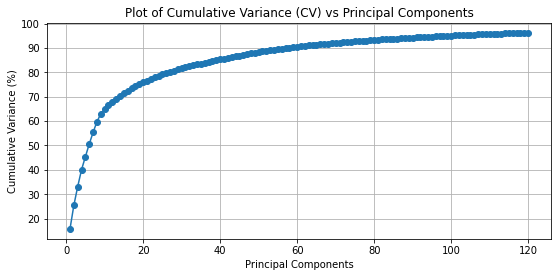

In [0]:
### Evaluate PCA Explained Variance to determine components required to achieve 9% explained variance.

from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import numpy as np

n_components = 120
pca = PCA(
    k = n_components, 
    inputCol = 'VectorAssembler_features', 
    outputCol = 'pcaFeatures'
).fit(model_data_train)

df_pca = pca.transform(model_data_train)

#print('Explained Variance Ratio', pca.explainedVariance.toArray(), 'Sum:', np.sum(pca.explainedVariance.toArray()))
#df_pca.show(10)

partial_variance = pca.explainedVariance[:n_components].cumsum()

cum_variance = []
par_variance = []

k_values = [i+1 for i in range(n_components)]

for k in k_values:
    cum_variance.append(partial_variance[k-1] * 100)
    if k == 1:
      par_variance.append(partial_variance[k-1] * 100)
    else:
      par_variance.append((partial_variance[k-1] - partial_variance[k-2]) * 100)

variances = {'Component': k_values,
            'Partial Variance (%)': par_variance,
            'Cumulative Variance (%)': cum_variance}
df = pd.DataFrame(variances)

display(HTML(df.to_html(index=False)))

# # Plot of Cumulative Variance (CV) vs Principal Components
# fig = plt.figure(figsize=(7,3))
# ax = fig.add_axes([0,0,1,1])
# ax.plot(k_values, cum_variance, 'bo-', color='#1F77B4')
# ax.set_ylabel('Cumulative Variance (%)')
# ax.set_xlabel('Principal Components')
# ax.set_title('Plot of Cumulative Variance (CV) vs Principal Components')
# #plt.grid()

# i = 0
# for x, y in zip(k_values, cum_variance):
#   plt.annotate('PV= '+str(round(par_variance[i], 2)),
#                (x, y),
#                textcoords = "offset points",
#                xytext = (0, 5),
#                ha='center')
#   i += 1


# Plot of Cumulative Variance (CV) vs Principal Components
fig = plt.figure(figsize=(7,3))
ax = fig.add_axes([0,0,1,1])
ax.plot(k_values, cum_variance, 'bo-', color='#1F77B4')
ax.set_ylabel('Cumulative Variance (%)')
ax.set_xlabel('Principal Components')
ax.set_title('Plot of Cumulative Variance (CV) vs Principal Components')
plt.grid()

# i = 0
# for x, y in zip(k_values, cum_variance):
#   plt.annotate(,
#                (x, y),
#                textcoords = "offset points",
#                xytext = (0, 5),
#                ha='center')
#   i += 1


print()

In [0]:
# writing train and test dataset to blob storage in parquet format to be used for model algorithms

# model_data_train.write.mode('overwrite').parquet(f"{blob_url}/model_train_data_full_pca_complete_v1")
# model_data_test.write.mode('overwrite').parquet(f"{blob_url}/model_test_data_full_pca_complete_v1")

model_data_train.write.mode('overwrite').parquet(f"{blob_url}/model_train_data_full_pca_complete_v2")
model_data_test.write.mode('overwrite').parquet(f"{blob_url}/model_test_data_full_pca_complete_v2")

#### 5.2. Logistic regression

> - Logistic regresion is probably one of the most common tools in supervised learning, in particular for classification. 
> - Logistic regression is a way to model the linear relationship between one or more arbitrary independent variables and binary or categorical dependent variables. 
> - Logistic regression transforms the continuous infinite scale into a scale between 0 and 1 (Sigmoid Function or Sigmoid activation). 
> - It can be used for both inference and for prediction.

In [0]:
# Reading the train and test data from blob storage for running the models

# model_data_train = spark.read.parquet(f"{blob_url}/model_train_data_full_pca_complete_v1/*")
# model_data_test = spark.read.parquet(f"{blob_url}/model_test_data_full_pca_complete_v1/*")

model_data_train = spark.read.parquet(f"{blob_url}/model_train_data_full_pca_complete_v2/*")
model_data_test = spark.read.parquet(f"{blob_url}/model_test_data_full_pca_complete_v2/*")


In [0]:
from pyspark.ml.classification import LogisticRegression

start_lr = time.time()

lr = LogisticRegression(featuresCol='pca_features',labelCol='departure_delay_boolean', regParam = 0.2, fitIntercept=True, elasticNetParam=0.0, maxIter=10, threshold = 0.6)

stages_lr = [lr]
pipeline_lr = Pipeline(stages=stages_lr)
lr_model = pipeline_lr.fit(model_data_train)
lrPredictions = lr_model.transform(model_data_test)
print(f'lr model completed job in {time.time() - start_lr} seconds.')
lr_time_model = time.time() - start_lr

lr model completed job in 178.91673159599304 seconds.

In [0]:
# Model Evaluation with scikit learn
y_true_lr = lrPredictions.select(['departure_delay_boolean']).collect()
y_pred_lr = lrPredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_lr, y_pred_lr))
print(confusion_matrix(y_true_lr, y_pred_lr))

precision recall f1-score support

 0.0 0.86 0.93 0.89 5209208
 1.0 0.57 0.39 0.47 1291769

 accuracy 0.82 6500977
 macro avg 0.72 0.66 0.68 6500977
weighted avg 0.80 0.82 0.81 6500977

[[4832116 377092]
 [ 785763 506006]]

In [0]:
# print results with helper function
print_results(lrPredictions)

Sensitivity: 39.17%
Specificity: 92.76%
False positive rate: 7.24%
False negative rate: 60.83%
Recall: 39.17%
Precision: 57.30%
f1: 46.53%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 506006 785763
Actual-on time 377092 4832116

Out[36]:

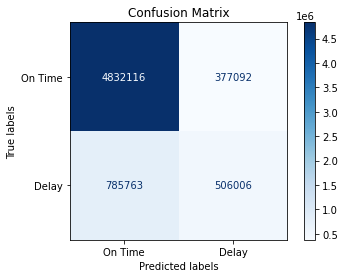

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_lr = confusion_matrix(y_true_lr, y_pred_lr)
cm_lr_display = ConfusionMatrixDisplay(cm_lr, display_labels=['On Time', 'Delay'])
cm_lr_display.plot(cmap='Blues', values_format='d')
cm_lr_display.ax_.set(title='Confusion Matrix')
cm_lr_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')


#### 5.3. Random Forest Classifier

> - Random Forest is a supervised learning algorithm that can be used for classification as well as regression. 
> - Random forest consists of a large number of individual decision tress that operate as an ensemble (or group) of decision trees. 
> - Initially, it selects a random subset of the total training data, then it fits a decision tree to that subset of the data, creating a "forest" of multiple decision trees all trained on slightly different versions of the training data.
> - When it comes time to make predictions, each new data point is run through all of the trees in the forest, with each tree getting a single vote as to it's class. The class with the highest votes is the prediction.

In [0]:
# from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

start_rf = time.time()
rf = RandomForestClassifier(labelCol='departure_delay_boolean',
                            featuresCol='pca_features',
                            maxDepth=5)

stages_rf = [rf]
pipeline_rf = Pipeline(stages=stages_rf)
rf_model = pipeline_rf.fit(model_data_train)
rfPredictions = rf_model.transform(model_data_test)

print(f'rf model completed job in {time.time() - start_rf} seconds.')
rf_time_model = time.time() - start_rf

rf model completed job in 234.04641246795654 seconds.

In [0]:
# Model Evaluation

eval_accuracy = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="precision")
eval_recall = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="recall")
evaluator = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="f1")
evaluator.evaluate(rfPredictions)

# Model Evaluation with scikit learn
y_true_rf = rfPredictions.select(['departure_delay_boolean']).collect()
y_pred_rf = rfPredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_rf, y_pred_rf))
print(confusion_matrix(y_true_rf, y_pred_rf))

precision recall f1-score support

 0.0 0.88 0.77 0.82 5209208
 1.0 0.38 0.58 0.46 1291769

 accuracy 0.73 6500977
 macro avg 0.63 0.67 0.64 6500977
weighted avg 0.78 0.73 0.75 6500977

[[4013363 1195845]
 [ 545112 746657]]

In [0]:
# print results with helper function
print_results(rfPredictions)

Sensitivity: 57.80%
Specificity: 77.04%
False positive rate: 22.96%
False negative rate: 42.20%
Recall: 57.80%
Precision: 38.44%
f1: 46.17%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 746657 545112
Actual-on time 1195845 4013363

Out[40]:

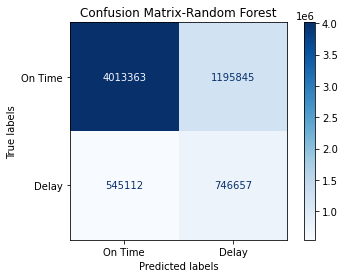

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot confusion matrix

cm_rf = confusion_matrix(y_true_rf, y_pred_rf)
cm_rf_display = ConfusionMatrixDisplay(cm_rf, display_labels=['On Time', 'Delay'])
cm_rf_display.plot(cmap='Blues', values_format='d')
cm_rf_display.ax_.set(title='Confusion Matrix-Random Forest')
cm_rf_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

#### 5.4. Gradient Boosted Trees

**Gradient Boosted Tree is displaying an OOM Error when using PCA. Therefore, we have decided not to include it in our PCA Evaluation**

About Gradient Boosted Trees

Gradient Boosted Trees (GBTs) is a learning algorithm for classification. 
> - It supports binary labels, as well as both continuous and categorical features.
> - Like Random Forest, GBT is also one of ensembling methods that combine the outputs from individual trees. However, unlike random forest, GBT use a method called `boosting` that combines weak learners sequentially so that each tree corrects the error from the previous one .
> - After each full cycle of decision tree build, the sampled dataset is weighted - misclassified data increases it weights to emphasize the most difficult cases so that when the next decision tree is built the weighted data is used, therefore subsequent learners will focus more on mis-classified data during training.
> - Random forest creates independant decision trees and combines them in parallel to calculate the average result at the end, whereas GBT combines result along the way.
> - GBT has a lot of model capacity so they can handle very complex relationships and decision boundaries, however, as with all models with high capacity, this can lead to overfitting very quickly

In [0]:
# Reference used for building Gradient Boosted tree model: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html

# Build a gradient boosted tree model

start_gbt = time.time()
gbt = GBTClassifier(featuresCol='pca_features', 
              labelCol='departure_delay_boolean', 
              maxBins=10,
              maxDepth=10,
              minInstancesPerNode=10,
              minInfoGain=0.001,
              stepSize=0.2,
              maxIter=10, 
              )


# Setup pipeline
stages_gbtClassifier = [gbt]
pipeline_gbt = Pipeline(stages=stages_gbtClassifier)

# Train the GBT model
gbt_model = pipeline_gbt.fit(model_data_train)

gbpredictions = gbt_model.transform(model_data_test)

print(f'gbt model completed job in {time.time() - start_gbt} seconds.')
gbt_time_model = time.time() - start_gbt

gbt model completed job in 312.93037962913513 seconds.

**GBT Model Evaluation**

In [0]:
# Model Evaluation

eval_accuracy = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="precision")
eval_recall = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="recall")

evaluator = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="f1")
evaluator.evaluate(gbpredictions)

# Model Evaluation with scikit learn
y_true_gbt = gbpredictions.select(['departure_delay_boolean']).collect()
y_pred_gbt = gbpredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_gbt, y_pred_gbt))
print(confusion_matrix(y_true_gbt, y_pred_gbt))

precision recall f1-score support

 0.0 0.89 0.77 0.83 5209208
 1.0 0.40 0.62 0.49 1291769

 accuracy 0.74 6500977
 macro avg 0.65 0.70 0.66 6500977
weighted avg 0.79 0.74 0.76 6500977

[[4027713 1181495]
 [ 489458 802311]]

In [0]:
# print results with helper function

print_results(gbpredictions)


Sensitivity: 62.11%
Specificity: 77.32%
False positive rate: 22.68%
False negative rate: 37.89%
Recall: 62.11%
Precision: 40.44%
f1: 48.99%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 802311 489458
Actual-on time 1181495 4027713

Out[49]:

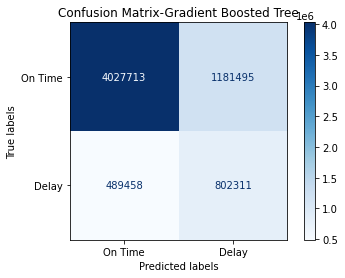

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot Confusion Matrix

cm_gbt = confusion_matrix(y_true_gbt, y_pred_gbt)
cm_gbt_display = ConfusionMatrixDisplay(cm_gbt, display_labels=['On Time', 'Delay'])
cm_gbt_display.plot(cmap='Blues', values_format='d')
cm_gbt_display.ax_.set(title='Confusion Matrix-Gradient Boosted Tree')
cm_gbt_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

#### 5.5. Support Vector Machine

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

We used the **LinearSVC** class in PySpark because we are doing support vector classification - and not regression. It is important to note that LinearSVC in Pyspark optimizes the Hinge Loss using the OWLQN optimizer. It only supports L2 regularization currently.

**Comparison of SVC with other models:**

1) SVC vs Random Forest or Gradient Boosted tree 

> - SVM requires more computation time for achieving almost the same accuracy as with other classifiers such as Random forest.
> - Random Forest is intrinsically suited for multiclass problems, while SVM is intrinsically two-class. For multiclass problem, while using SVM, it is needed to reduce it into multiple binary classification problems.
> - Random Forest works well with a mixture of numerical and categorical features, even when features are on the various scales. Basically, with Random Forest we can use data as they are. SVM maximizes the "margin" and thus relies on the concept of "distance" between different points. In that case it falls on us to decide if "distance" is meaningful. As a consequence, in SVM, one-hot encoding for categorical features is a must-do. Further, min-max or other scaling is highly recommended at preprocessing step for SVM.
> - For a classification problem like the one that we built our model on, Random Forest gives the probability of belonging to class whereas SVM gives the distance to the boundary, Hence, for those problems, SVM generally performs better than Random Forest. But the caveat here is that, for SVM, we still need to convert it to probability somehow if we need probability.

2) SVC vs Logistic Regression
Comparing SVC vs Logistic Regression, SVC tries to find an optimal hyperplane rather than focusing on maximizing the probability of the data. It is less prone to overfitting compared to logistic regression, however, may take longer to train. We expected SVM to perform at par or better than logistic regression.

**SVM GridSearch**

In [0]:
grid_search = False

if(grid_search):
  
  lsvc_estimator = LinearSVC(featuresCol='VectorAssembler_features', labelCol='departure_delay_boolean')
  
  paramGrid_svc = (ParamGridBuilder()
               .addGrid(svc.regParam, [0.15, 0.05, 0.001])
               .addGrid(svc.maxIter, [0, 10, 100]) 
               .addGrid(svc.fitIntercept, [True, False])
               .addGrid(svc.standardization, [True, False])
               .addGrid(svc.aggregationDepth, [2, 3])
               .addGrid(svc.aggregationDepth, [1e-04, 1e-06])
               .addGrid(svc.threshold, [0.0001,0])   
               .build())

  svc_evaluator = MulticlassClassificationEvaluator(labelCol='departure_delay_boolean', metricName='f1')

  svc_cv = CrossValidator(estimator = lsvc_estimator,
                        estimatorParamMaps = paramGrid_svc,
                        evaluator = svc_evaluator,
                        numFolds = 3)

  svc_model = svc_cv.fit(model_data_train)

  print(svc_model)

**SVM Model Pipeline**

In [0]:
start_svc = time.time()
lsvc = LinearSVC(featuresCol='pca_features',
                 labelCol='departure_delay_boolean',
                 maxIter=100, regParam=0.2, tol=1e-05, fitIntercept=True, standardization=True,
                 threshold=0.0001, aggregationDepth=2 )

stages_lsvc = [lsvc]
pipeline_lsvc = Pipeline(stages=stages_lsvc)
lsvc_model = pipeline_lsvc.fit(model_data_train)
lsvcPredictions = lsvc_model.transform(model_data_test)
print(f'svc model completed job in {time.time() - start_svc} seconds.')
svc_time_model = time.time() - start_svc



svc model completed job in 199.68533158302307 seconds.

**SVM Model Evaluation**

In [0]:
# Model Evaluation with scikit learn
y_true_lsvc = lsvcPredictions.select(['departure_delay_boolean']).collect()
y_pred_lsvc = lsvcPredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_lsvc, y_pred_lsvc))
print(confusion_matrix(y_true_lsvc, y_pred_lsvc))

precision recall f1-score support

 0.0 0.88 0.76 0.81 5209208
 1.0 0.37 0.58 0.46 1291769

 accuracy 0.72 6500977
 macro avg 0.63 0.67 0.64 6500977
weighted avg 0.78 0.72 0.74 6500977

[[3949946 1259262]
 [ 539496 752273]]

In [0]:
print_results(lsvcPredictions)

Sensitivity: 58.24%
Specificity: 75.83%
False positive rate: 24.17%
False negative rate: 41.76%
Recall: 58.24%
Precision: 37.40%
f1: 45.55%
########### Confusion Matrix ###########
 Predicted-delay Predicted-on time
Actual-delay 752273 539496
Actual-on time 1259262 3949946

Out[54]:

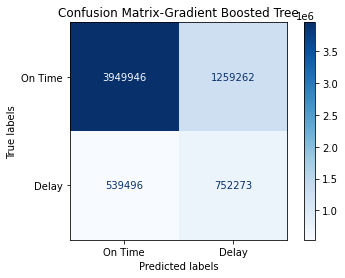

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
#Plot Confusion Matrix

cm_lsvc = confusion_matrix(y_true_lsvc, y_pred_lsvc)
cm_lsvc_display = ConfusionMatrixDisplay(cm_lsvc, display_labels=['On Time', 'Delay'])
cm_lsvc_display.plot(cmap='Blues', values_format='d')
cm_lsvc_display.ax_.set(title='Confusion Matrix-Gradient Boosted Tree')
cm_lsvc_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')

**XGBoost Evaluation**

In [0]:
xgb = XgboostClassifier(featuresCol='VectorAssembler_features', 
              labelCol='departure_delay_boolean', 
              maxBins=10,
              maxDepth=5,
              minInstancesPerNode=10,
              minInfoGain=0.001,
              stepSize=0.2,
              maxIter=10,
              missing = 0.0,
              n_estimators = 50 
              )

# Setup pipeline
stages_xgbClassifier = [xgb]
pipeline_xgb = Pipeline(stages=stages_xgbClassifier)


In [0]:

# Train the XGB model
xgb_model = pipeline_xgb.fit(model_data_train)

xgbpredictions = xgb_model.transform(model_data_test)



In [0]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="precision")
eval_recall = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="recall")

evaluator = MulticlassClassificationEvaluator(labelCol="departure_delay_boolean", predictionCol="prediction", metricName="f1")
evaluator.evaluate(xgbpredictions)


Out[15]: 0.7851962250256446

In [0]:
y_true_xgb = xgbpredictions.select(['departure_delay_boolean']).collect()
y_pred_xgb = xgbpredictions.select(['prediction']).collect()

# Print metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_xgb, y_pred_xgb))
print(confusion_matrix(y_true_xgb, y_pred_xgb))

precision recall f1-score support

 0.0 0.90 0.80 0.85 5209208
 1.0 0.45 0.64 0.53 1291769

 accuracy 0.77 6500977
 macro avg 0.67 0.72 0.69 6500977
weighted avg 0.81 0.77 0.79 6500977

[[4186796 1022412]
 [ 464019 827750]]

Out[17]:

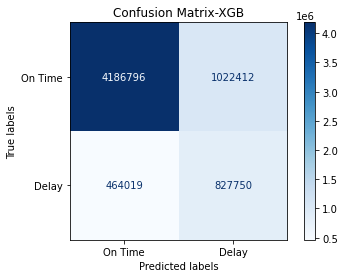

[Text(0.5, 0, 'Predicted labels'), Text(0, 0.5, 'True labels')]

In [0]:
# Plot Confusion Matrix

cm_xgb = confusion_matrix(y_true_xgb, y_pred_xgb)
cm_xgb_display = ConfusionMatrixDisplay(cm_xgb, display_labels=['On Time', 'Delay'])
cm_xgb_display.plot(cmap='Blues', values_format='d')
cm_xgb_display.ax_.set(title='Confusion Matrix-XGB')
cm_xgb_display.ax_.set(xlabel='Predicted labels', ylabel='True labels')